# Importation et fonctions

In [ ]:
import os
if os.path.isdir("CMaps")==False:
  ! mkdir ~/.kaggle
  ! cp kaggle.json ~/.kaggle/
  ! chmod 600 ~/.kaggle/kaggle.json
  !kaggle datasets download -d behrad3d/nasa-cmaps
  !unzip -q 'nasa-cmaps.zip'

 89% 11.0M/12.3M [00:01<00:00, 17.4MB/s]
100% 12.3M/12.3M [00:01<00:00, 10.6MB/s]


## Fonctions analyse de données et formatage de dataset

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tabulate import tabulate
import random
import tensorflow as tf
import sklearn
from sklearn.model_selection import train_test_split

# Permet de plot proprement la valeur prédite et la valeur réelle
def plotResults(y_test, y_test_hat,title="Plot"):
  y_test=pd.DataFrame(y_test)
  indices = np.arange(len(y_test_hat))
  wth= 0.6
  plt.figure(figsize=(70,30))
  true_values = [int(x) for x in y_test.values]
  predicted_values = list(y_test_hat)

  plt.bar(indices, true_values, width=wth,color='b', label='True RUL')
  plt.bar([i for i in indices], predicted_values, width=0.5*wth, color='r', alpha=0.7, label='Predicted RUL')
  plt.title(title,size=40)

  plt.legend(prop={'size': 40})
  plt.tick_params(labelsize=40)
  plt.show()


#Permet de plot les diagrammes capteurs/RUL
def plotSensor(X,sensorName,sensorDic):
  plt.figure(figsize=(13,5))
  for i in X['id'].unique():
      if (i % 10 == 0):
          plt.plot('RUL', sensorName,
                    data=X[X['id']==i].rolling(8).mean())
  plt.xlim(250, 0)
  plt.xticks(np.arange(0, 275, 25))
  plt.ylabel(sensorDic[sensorName])
  plt.xlabel('Remaining Useful Life')
  plt.show()

#Creates several groups of consecutives observations of nbOfPicks random samples per ID for a given dataset
def takeRandom(XTrain,XTest,RULTrain,RULTest,trainID,testID,nbOfPicks,nbStepsToPredict=15):
  List=XTrain.copy()
  ListTest=XTest.copy()
  ListTest["id"]=testID
  List["id"]=trainID
  selection,newY=[],[] #A list of list which contains one list of samples for each id
  for i in range(1,List["id"].max()+1): #We take a sample for each id, considering they start at 1
    nbOfSeries=min((RULTrain["cycle"][i]-nbOfPicks)//nbOfPicks,(RULTest["cycle"][i]-nbOfPicks)//nbOfPicks)
    idList=List.loc[List['id'] ==i]
    idList=idList.drop("id",axis=1)
    idListTest=ListTest.loc[ListTest['id'] ==i]
    idListTest=idListTest.drop("id",axis=1)
    for k in range(nbOfSeries-1): #We take as many different samples as we can for each id, should -1 be kept?
      sample,sampleTest=[],[]
      index=random.randint(0,len(idList)-nbOfPicks)
      indexTest=random.randint(0,len(idListTest)-nbOfPicks)
      for j in range(nbOfPicks):
        sample.append(idList.iloc[index+j])
        sampleTest.append(idListTest.iloc[indexTest+j])
      newY.append(1) if index+nbOfPicks-1+nbStepsToPredict>=len(idList) else newY.append(0) #If the index of the last point + nbOfPicks is >= than len(list), then the RUL has been reached
      newY.append(1) if indexTest+nbOfPicks-1+nbStepsToPredict>=RULTest["cycle"][i] else newY.append(0) #Value is the RUL, we then add the previous number of cycles in order to have the total life cycle
      selection.append(sample)
      selection.append(sampleTest)
  df=pd.DataFrame(list(zip(selection,newY)),columns=["selection","newY"])
  df=df.sample(frac=1)
  a, b = np.split(df, [int(.8*len(df))]) #We split the dataset into train and test parts
  trainNeural,yNeural=a["selection"],a["newY"]
  testNeural,yTestNeural=b["selection"],b["newY"]
  trainNeural,testNeural=list(trainNeural),list(testNeural)
  trainNeural,testNeural=tf.reshape(trainNeural,(len(yNeural),nbOfPicks,XTrain.shape[1])),tf.reshape(testNeural,(len(yTestNeural),nbOfPicks,XTest.shape[1]))
  return trainNeural,yNeural,testNeural,yTestNeural


def realPlot(title,data,y,predictions,var1,var2):
  y=y.tolist() #From pandas.Series to list
  green=[] #Anomaly correctly predicted
  red=[] #Anomaly wrongly predicted
  blue=[] #Normal correctly predicted
  orange=[] #Normal wrongly predicted
  for i in range(len(y)):
    if  y[i]==1 and predictions[i]==1:green.append(data[i])
    elif y[i]==0 and predictions[i]==0:blue.append(data[i])
    elif y[i]==0 and predictions[i]==1:orange.append(data[i])
    else: red.append(data[i])
  fig, ax = plt.subplots()

  nbOutliers=sum(y)
  nbPure=len(y)-nbOutliers

  print("Nombre d'anomalies mal prédites: ",len(red))
  print("Nombre d'anomalies bien prédites: ",len(green))
  print("Nombre de points sains bien prédits: ",len(blue))
  print("Nombre de points sains mal prédits: ",len(orange))
  if(len(blue)!=0): #All these because if there is an empty list, it will crash (if the model is either too good or too bad)
    ax.scatter(*zip(*blue),color="blue",label="True normal")
  if(len(orange)!=0): ax.scatter(*zip(*orange),color="orange",label="False anomaly")
  if(len(green)!=0): ax.scatter(*zip(*green),color="green",label="True anomaly")
  if(len(red)!=0): ax.scatter(*zip(*red),color="red",label="False normal")
  ax.legend()
  plt.title("Fiabilité de la prédiction "+title)
  plt.xlabel(paramDictionary[var1],fontsize=14)
  plt.ylabel(paramDictionary[var2],fontsize=14)
  errorAno="{number}/{total}".format(number=len(red),total=nbOutliers)
  errorPure="{number}/{total}".format(number=len(orange),total=nbPure)
  return errorAno,errorPure

## Fonctions de gestion de performances

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score,classification_report,accuracy_score
from operator import itemgetter

# Returns some performances metrics given trueY and predictedY
def performances(yTrue, yHat, label='Test'):
  mse = mean_squared_error(yTrue, yHat)
  rmse = np.sqrt(mse)
  r2 = r2_score(yTrue,yHat)
  proportions=yTrue-yHat
  negProp = len(list(filter(lambda x: (x < 0), proportions)))/len(proportions)

  #We check the mean of the over-predicted RULs (negative means true<predicted)
  negMean=-np.mean(list(filter(lambda x: (x < 0), proportions)))

  #We check the mean of the under-predicted RULs
  posMean=np.mean(list(filter(lambda x: (x > 0), proportions)))
  print('{} set RMSE:{}, R²:{}'.format(label, rmse, r2))
  return rmse,r2,negProp,negMean,posMean

#Prints in a nice way performances matrixes
def printResMatrix(matrixTrain,matrixTest,colnames,toPrint="res"):
  if toPrint=="res":
    matrixTrain=sorted(matrixTrain, key=itemgetter(1)) #On trie le tableau de résultat en fonction du RMSE des modèles
    matrixTest=sorted(matrixTest, key=itemgetter(1))
  if toPrint=="res":print("Les résultats des modèles en Train, triés par RMSE décroissant:")
  print(tabulate(matrixTrain, headers=colnames, tablefmt="grid", showindex=False)) #tablefmt="latex" pour obtenir directement du code latex, idem avec html, à voir pour rapport
  print("\n")
  if toPrint=="res":print("Les résultats des modèles en Test, triés par RMSE décroissant:")
  print(tabulate(matrixTest, headers=colnames, tablefmt="grid", showindex=False))

## Fonctions pour détection d'anomalies

In [ ]:
from sklearn.ensemble import IsolationForest

# Creates a dataset composed of pure observations and outliers, and creates a dataset only composed of outliers
def makeClean(data,toDrop,nbOutliersPerId=5):
  ano=data.loc[data['RUL']<=nbOutliersPerId*3-1] #We take 3*nbOutliersPerId outliers for the outliers-only dataset
  res=pd.concat([data.loc[data["RUL"]<nbOutliersPerId],data.loc[data['RUL']>=nbOutliersPerId]])
  res["outlier"]=[1 for i in range(len(data.loc[data["RUL"]<nbOutliersPerId]))]+[0 for j in range(len(data.loc[data['RUL']>=nbOutliersPerId]))]
  res,ano=res.sample(frac = 1),ano.sample(frac=1)
  yPrep=res['outlier']
  XPrep=res.drop(columns=toDrop+["outlier"]+["id"],axis=1)
  ano=ano.drop(columns=toDrop,axis=1)
  return XPrep,yPrep,ano

## Importation des données

In [ ]:
#On prépare le nom des différentes colonnes
index_names = ['id', 'cycle']
setting_names = ['setting_1', 'setting_2', 'setting_3']
sensor_names = ['s{}'.format(i+1) for i in range(0,23)]
columns = index_names + setting_names + sensor_names

In [ ]:
train=pd.read_csv("/content/CMaps/train_FD001.txt",sep=" ",names=columns)
test=pd.read_csv("/content/CMaps/test_FD001.txt",sep=" ",names=columns)
valid=pd.read_csv("/content/CMaps/RUL_FD001.txt",sep='\s+',header=None,index_col=None,names=['RUL'], )

valid.index = valid.index+1
valid = valid['RUL'].to_dict()

#We create matrixes to store all the performances we will obtain
resultMatrixTest=[]
resultMatrixTrain=[]
resMatrixNames=["Model","RMSE","R²","TooMuchProp","OverMean","UnderMean"]

anomalyResultsTrain=[]
anomalyResultsTest=[]
anomalyNames=["Model","var1","var2","Accuracy","ErrorAno","ErrorPure"]

neuralMatrixTrain=[]
neuralMatrixTest=[]
neuralNames=["Model","False positive","False negative","Number of points","Precision"]

#We create a dictionary of sensors in order to access what they represent (for plot labels)
paramDictionary={}
dict_list=[
"Setting 1",
"Setting 2",
"Setting 3",
"Fan inlet temperature (◦R)", #1
"LPC outlet temperature (◦R)", #2
"HPC outlet temperature (◦R)", #3
"LPT outlet temperature (◦R)", #4
"Fan inlet Pressure (psia)", #5
"Bypass-duct pressure (psia)", #6
"HPC outlet pressure (psia)", #7
"Physical fan speed (rpm)", #8
"Physical core speed (rpm)", #9
"Engine pressure ratio(P50/P2)", #10
"HPC outlet Static pressure (psia)", #11
"Ratio of fuel flow to Ps30 (pps/psia)", #12
"Corrected fan speed (rpm)", #13
"Corrected core speed (rpm)", #14
"Bypass Ratio ", #15
"Burner fuel-air ratio", #16
"Bleed Enthalpy", #17
"Required fan speed", #18
"Required fan conversion speed", #19
"High-pressure turbines Cool air flow", #20
"Low-pressure turbines Cool air flow" ]

i=-2
for x in dict_list :
    paramDictionary['s'+str(i)]=x
    i+=1

paramDictionary['setting_1']=paramDictionary.pop('s-2')
paramDictionary['setting_2']=paramDictionary.pop('s-1')
paramDictionary['setting_3']=paramDictionary.pop('s0')

In [ ]:
print(train.shape)
print(test.shape)

(20631, 28)
(13096, 28)


# Analyse de données






## Statistiques

On affiche les stats de chaque variable, pour déjà avoir une vision d'ensemble des données dont on dispose, mais aussi pour pouvoir repérer les variables constantes ou à variance très faible. On peut créer une fonction qui récupérerait le tableau et se débarasserait de toutes les variables à variance nulle.

In [ ]:
train.head()

,id,cycle,setting_1,setting_2,setting_3,s1,s2,s3,s4,s5,...,s14,s15,s16,s17,s18,s19,s20,s21,s22,s23
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,NaN,NaN
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,NaN,NaN
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,NaN,NaN
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,NaN,NaN
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,NaN,NaN


In [ ]:
train.describe()

,id,cycle,setting_1,setting_2,setting_3,s1,s2,s3,s4,s5,...,s14,s15,s16,s17,s18,s19,s20,s21,s22,s23
count,20631.000000,20631.000000,20631.000000,20631.000000,20631.0,20631.00,20631.000000,20631.000000,20631.000000,2.063100e+04,...,20631.000000,20631.000000,2.063100e+04,20631.000000,20631.0,20631.0,20631.000000,20631.000000,0.0,0.0
mean,51.506568,108.807862,-0.000009,0.000002,100.0,518.67,642.680934,1590.523119,1408.933782,1.462000e+01,...,8143.752722,8.442146,3.000000e-02,393.210654,2388.0,100.0,38.816271,23.289705,NaN,NaN
std,29.227633,68.880990,0.002187,0.000293,0.0,0.00,0.500053,6.131150,9.000605,1.776400e-15,...,19.076176,0.037505,1.387812e-17,1.548763,0.0,0.0,0.180746,0.108251,NaN,NaN
min,1.000000,1.000000,-0.008700,-0.000600,100.0,518.67,641.210000,1571.040000,1382.250000,1.462000e+01,...,8099.940000,8.324900,3.000000e-02,388.000000,2388.0,100.0,38.140000,22.894200,NaN,NaN
25%,26.000000,52.000000,-0.001500,-0.000200,100.0,518.67,642.325000,1586.260000,1402.360000,1.462000e+01,...,8133.245000,8.414900,3.000000e-02,392.000000,2388.0,100.0,38.700000,23.221800,NaN,NaN
50%,52.000000,104.000000,0.000000,0.000000,100.0,518.67,642.640000,1590.100000,1408.040000,1.462000e+01,...,8140.540000,8.438900,3.000000e-02,393.000000,2388.0,100.0,38.830000,23.297900,NaN,NaN
75%,77.000000,156.000000,0.001500,0.000300,100.0,518.67,643.000000,1594.380000,1414.555000,1.462000e+01,...,8148.310000,8.465600,3.000000e-02,394.000000,2388.0,100.0,38.950000,23.366800,NaN,NaN
max,100.000000,362.000000,0.008700,0.000600,100.0,518.67,644.530000,1616.910000,1441.490000,1.462000e+01,...,8293.720000,8.584800,3.000000e-02,400.000000,2388.0,100.0,39.430000,23.618400,NaN,NaN


## Durée de vie des moteurs

Avec le diagramme de durée de vie des moteurs, on peut visualiser le RUL de )chaque moteur et ainsi avoir une vision plus aboutie de la différence entre chaque moteur. L'histogramme correspond à la même vision, mais plus condensée

In [ ]:
max_time_cycles_train=train[index_names].groupby('id').count() #The initial RUL
train['last_cycle'] = train['id'].map(max_time_cycles_train['cycle'].to_dict())
train['RUL'] = train['last_cycle'] - train['cycle']
train=train.drop(["last_cycle"],axis=1)

In [ ]:
max_time_cycles_test=test[index_names].groupby('id').count()
test['last_known_cycle'] = test['id'].map(max_time_cycles_test['cycle'].to_dict())
test['last_cycle'] = test['last_known_cycle'] + test['id'].map(valid)
test["RUL"] = test['last_cycle'] - test['cycle']
for i in range(1,len(max_time_cycles_test)+1):
  max_time_cycles_test["cycle"][i]=max_time_cycles_test["cycle"][i]+valid[i]

Text(0.5, 1.0, 'Répartition du RUL dans le dataset')

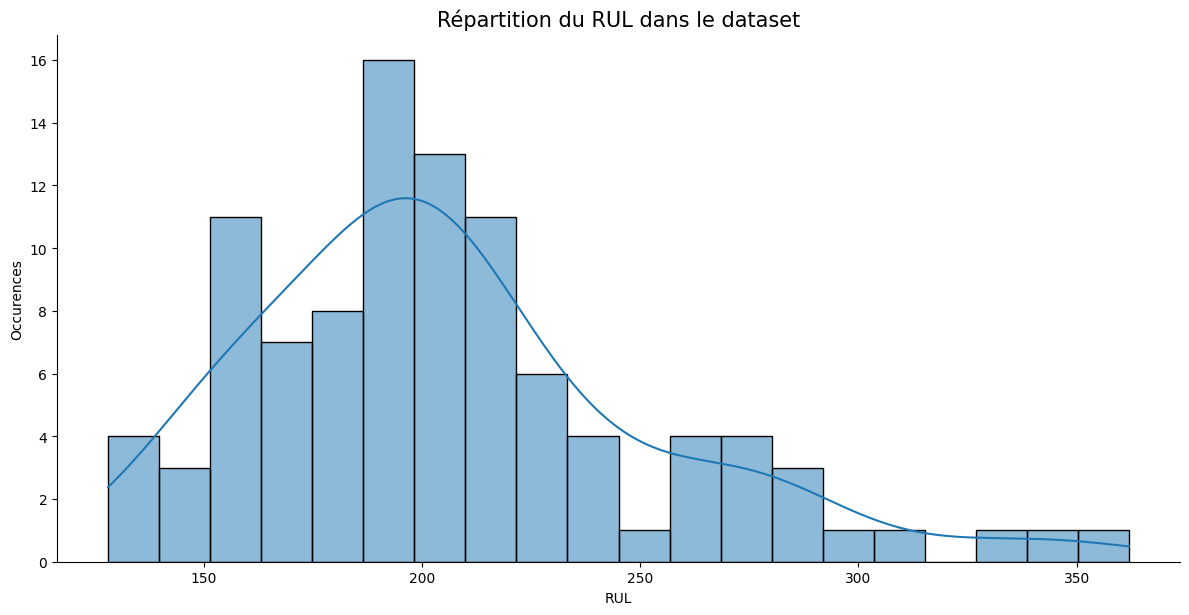

In [ ]:
sns.displot(max_time_cycles_train['cycle'],kde=True,bins=20,height=6,aspect=2)
plt.xlabel('RUL')
plt.ylabel('Occurences')
plt.title("Répartition du RUL dans le dataset",fontsize=15)

## Matrice de corrélation

<Axes: title={'center': 'Matrice de corrélation de Train'}>

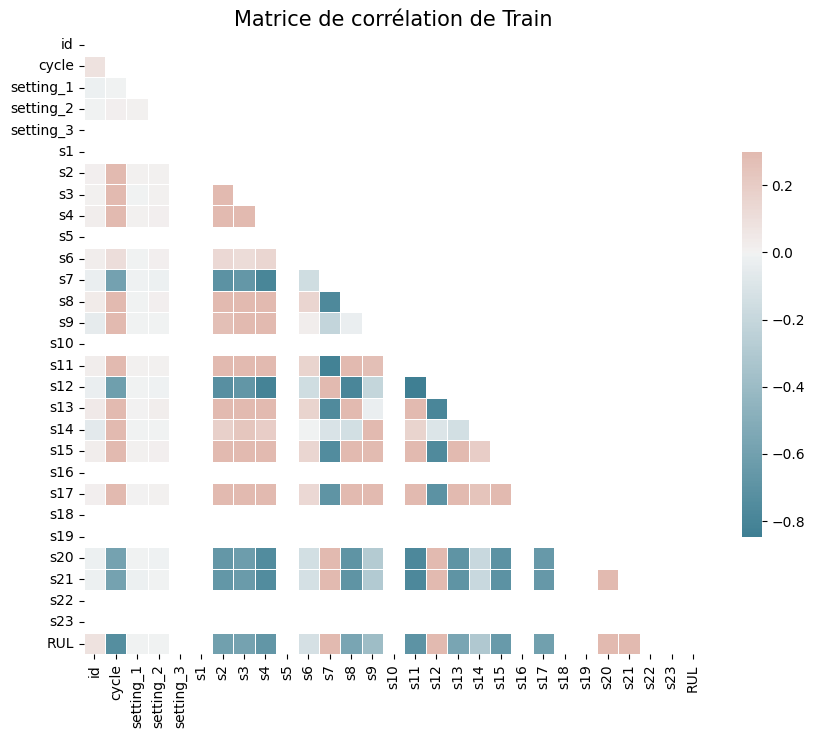

In [ ]:
corr = train.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
f,ax = plt.subplots(figsize=(10, 10))
cmap=sns.diverging_palette(220, 20, as_cmap=True)
plt.title("Matrice de corrélation de Train",fontsize=15)
sns.heatmap(corr,cmap=cmap,vmax=.3,center=0,square=True,linewidths=.5,cbar_kws={"shrink": .5},mask=mask)

## Diagramme paramètre/RUL

In [ ]:
# Plots the RUL/sensor diagram, commented as it takes some time and place to run
#for sensor in train.drop(['id','cycle','RUL'], axis=1).columns:
  #plotSensor(train,sensor,paramDictionary)

# Préparation des datasets

In [ ]:
train=train.drop(['s1','s5','s10','s16','s18','s19','s6','s22','s23'],axis=1) # Dropping all of the unwanted variables
test=test.drop(['s1','s5','s10','s16','s18','s19','s22','s23','s6',"last_known_cycle","last_cycle"],axis=1) # Dropping all of the unwanted variables
idTrain=train['id']
idTest=test["id"]

trainShuffled = train.sample(frac = 1)
testShuffled = test.sample(frac = 1)

drop_labels = index_names+["RUL"]+setting_names
y=trainShuffled['RUL']
y_train= y.clip(upper=125) #Boost performances
y_test=testShuffled['RUL']
dropClean=["cycle"]+["RUL"]+setting_names
XPrep,yPrep,XAno=makeClean(train,dropClean,nbOutliersPerId=5)
X_train=trainShuffled.drop(columns=drop_labels,axis=1)
X_test=testShuffled.drop(columns=drop_labels) # All the test values, without the cycles details and the sensors.

XTest1Value=test.groupby('id').last().reset_index().drop(columns=drop_labels) #Ici c'est à justifier

yTrainNonShuffled=train["RUL"]
yTestNonShuffled=test["RUL"]
train=train.drop(columns=drop_labels,axis=1)
test=test.drop(columns=drop_labels,axis=1)

In [ ]:
print("Nombre de missing values: ",train.isnull().sum().sum()) #Checking how many values are missing in the dataset
#train=train.dropna() #Removing missing values (commenté car pose problème avec les colonnes des capteurs 22 23 qui sont vides)

Nombre de missing values:  0


In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train)
colNames=list(X_train.columns)

X_train_scaled = scaler.transform(X_train)
X_train_scaled=pd.DataFrame(X_train_scaled,columns=colNames)

X_test_scaled = scaler.transform(X_test)
X_test_scaled=pd.DataFrame(X_test_scaled,columns=colNames)

XTest1ValueScaled=scaler.transform(XTest1Value)
XTest1ValueScaled=pd.DataFrame(XTest1ValueScaled,columns=colNames)

trainScaled=scaler.transform(train)
trainScaled=pd.DataFrame(trainScaled,columns=colNames)

testScaled=scaler.transform(test)
testScaled=pd.DataFrame(testScaled,columns=colNames)

# Régression

## Régression linéaire simple

On essaie de voir quel résultat le modèle le plus simple arrive à nous fournir

In [ ]:
from sklearn.linear_model import LinearRegression
reg = LinearRegression()
reg.fit(X_train_scaled,y_train) #Use y if you want to predict with the all test dataset afterthat. Otherwise, y_train gives way better performances

pred=reg.predict(X_train_scaled)
rmse,r2,negProp,negMean,posMean=performances(y_train,pred, label='Train')
resultMatrixTrain.append(["Régression simple",rmse,r2,negProp,negMean,posMean])

#predictions=reg.predict(X_test_scaled)
#rmse,r2,negProp,mean,negMean,posMean=performances(y_test,predictions,label="Test")
#resultMatrixTest.append(["Régression simple",rmse,r2,negProp,negMean,posMean])

predictions=reg.predict(XTest1ValueScaled)
rmse,r2,negProp,negMean,posMean=performances(list(valid.values()),predictions,label="Test")
resultMatrixTest.append(["Régression simple",rmse,r2,negProp,negMean,posMean])

Train set RMSE:21.491018701515106, R²:0.7340432868050523
Test set RMSE:21.900213406891673, R²:0.7222608196545948


## Régression avec XgBoost

Train set RMSE:18.289242255158964, R²:0.8073857659675403
Test set RMSE:18.292910804130802, R²:0.8062212771086563


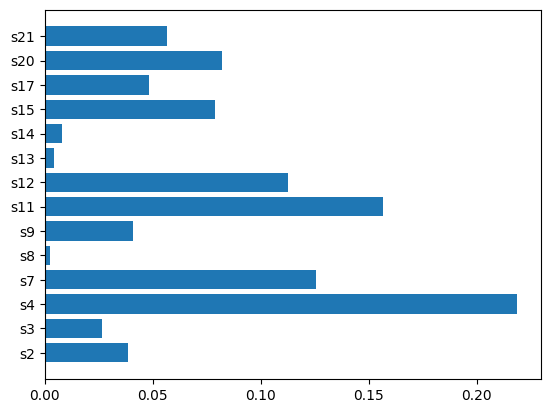

In [ ]:
import xgboost
#model= xgboost.XGBRegressor(n_estimators=110, learning_rate=0.02, gamma=0, subsample=0.8,colsample_bytree=0.5, max_depth=3)
model= xgboost.XGBRegressor(n_estimators=100, max_depth=2, eta=0.1, subsample=0.7, colsample_bytree=1,random_state=100)
model.fit(X_train,y_train)
plt.barh(X_train.columns, model.feature_importances_)

pred = model.predict(X_train)
rmse,r2,negProp,negMean,posMean=performances(y_train,pred, label='Train')
resultMatrixTrain.append(["Régression XgBoost",rmse,r2,negProp,negMean,posMean])

#prediction = model.predict(X_test)
#rmse,r2,negProp,,negMean,posMean=performances(y_test, prediction, label='Test')
#resultMatrixTest.append(["Régression XgBoost",rmse,r2,negProp,negMean,posMean])

prediction = model.predict(XTest1Value)
rmse,r2,negProp,negMean,posMean=performances(list(valid.values()), prediction, label='Test')
resultMatrixTest.append(["Régression XgBoost",rmse,r2,negProp,negMean,posMean])

## Régression avec Random Forest

Train set RMSE:6.801086201514463, R²:0.9733649502826393
Test set RMSE:17.71077019782031, R²:0.818358386180404


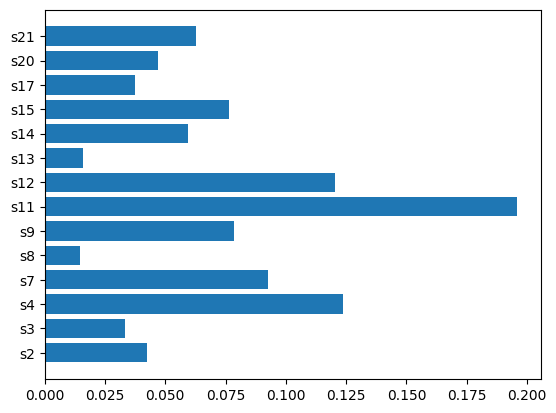

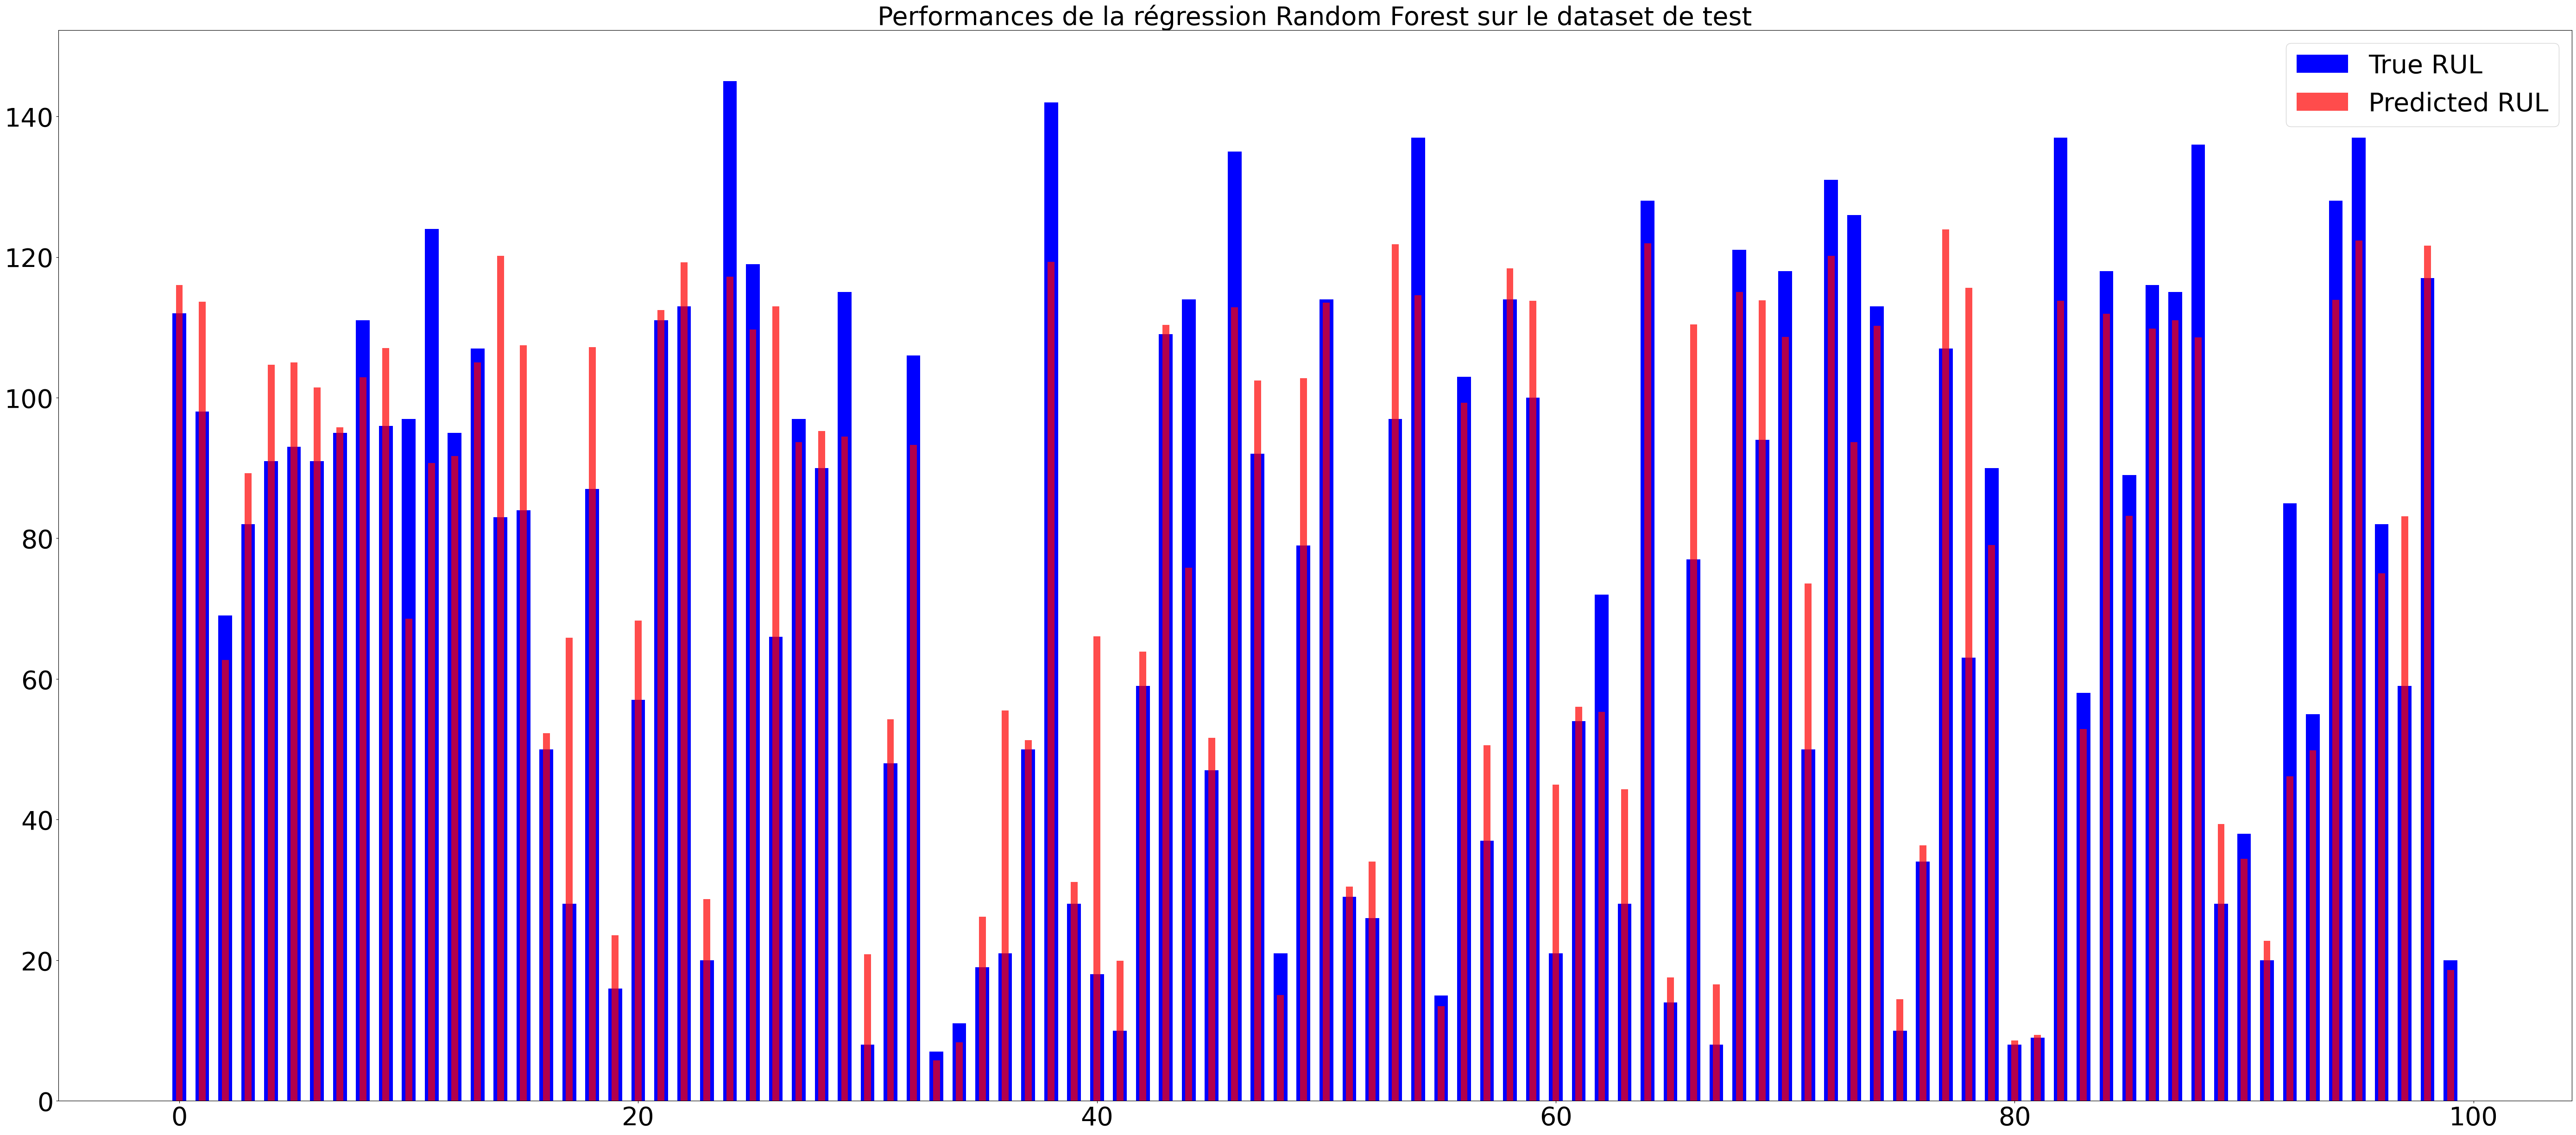

In [ ]:
from sklearn.ensemble import RandomForestRegressor
reg=RandomForestRegressor(n_jobs=-1,
                              n_estimators=100,
                              min_samples_leaf=1,
                              max_features='sqrt',random_state=100)
reg.fit(X_train,y_train)
plt.barh(X_train.columns, reg.feature_importances_)

pred=reg.predict(X_train)
rmse,r2,negProp,negMean,posMean=performances(y_train,pred, label='Train')
resultMatrixTrain.append(["Régression Random Forest",rmse,r2,negProp,negMean,posMean])

#predictions=reg.predict(X_test)
#rmse,r2,negProp,mean,negMean,posMean=performances(y_test,predictions,label="Test")
#resultMatrixTest.append(["Régression Random Forest",rmse,r2,negProp,negMean,posMean])

prediction = reg.predict(XTest1Value)
rmse,r2,negProp,negMean,posMean=performances(list(valid.values()),prediction,label="Test")
plotResults(valid.values(),prediction,"Performances de la régression Random Forest sur le dataset de test")
resultMatrixTest.append(["Régression Random Forest",rmse,r2,negProp,negMean,posMean])

# Classification binaire

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, MaxPool1D, LSTM, SimpleRNN, MaxPooling1D, Dropout, GlobalMaxPooling1D
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

dataFormat,yNeural,testNeural,yVerifNeural=takeRandom(trainScaled,testScaled,max_time_cycles_train,max_time_cycles_test,idTrain,idTest,15,nbStepsToPredict=15) #Le shuffle a dû tout détruire
yNeural=yNeural.reset_index(drop="True") #We reset the index and drop the corresponding column, otherwise all the indexes are random (corresponding to row number from the dataset)
yVerifNeural=yVerifNeural.reset_index(drop="True") #We reset the index and drop the corresponding column, otherwise all the indexes are random (corresponding to row number from the dataset)

## Classification binaire par LSTM

In [ ]:
modelLSTM = Sequential(
    [
        LSTM(10,return_sequences=True,input_shape=[None,dataFormat.shape[2]]),
        LSTM(10,return_sequences=True,input_shape=[None,dataFormat.shape[2]]),
        LSTM(10),
        Dense(1,activation=None)
    ])
modelLSTM.summary()
modelLSTM.compile(loss="MeanSquaredError", optimizer=tf.keras.optimizers.Adam(learning_rate=0.05), metrics=["MeanSquaredError"])
modelLSTM.fit(dataFormat,yNeural, validation_split=.25, epochs=50,batch_size=32,verbose=1)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, None, 10)          1000      
                                                                 
 lstm_7 (LSTM)               (None, None, 10)          840       
                                                                 
 lstm_8 (LSTM)               (None, 10)                840       
                                                                 
 dense_2 (Dense)             (None, 1)                 11        
                                                                 
Total params: 2691 (10.51 KB)
Trainable params: 2691 (10.51 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/10
36/36 [==============================] - 10s 55ms/step - loss: 0.0320 - mean_squared_error: 0.0320 - val_loss: 0.0517 - val_mean_squared_erro

48/48 [==============================] - 1s 5ms/step


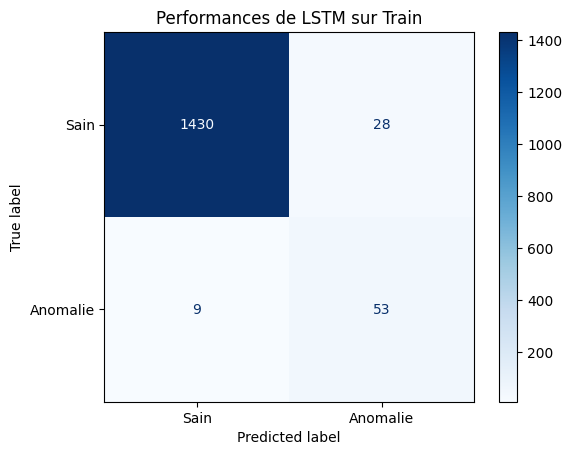

12/12 [==============================] - 0s 6ms/step


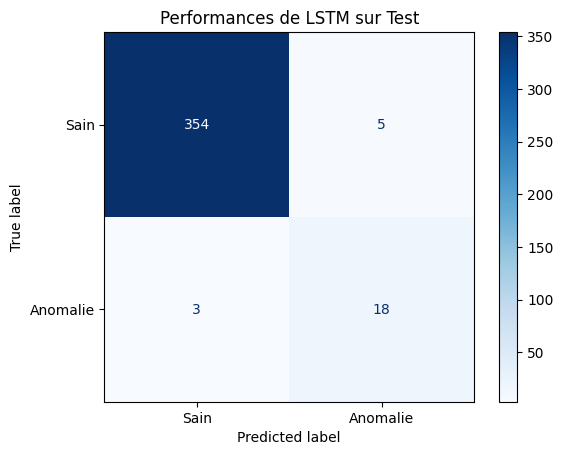

In [ ]:
pred=modelLSTM.predict(dataFormat)
pred=np.round(pred)

falsePositiveTrain=0
falseNegativeTrain=0
for i in range(len(pred)):
  if(pred[i]!=yNeural[i]):
    if(pred[i]==0 and yNeural[i]==1): falseNegativeTrain=falseNegativeTrain+1
    else:falsePositiveTrain=falsePositiveTrain+1
neuralMatrixTrain.append(["LSTM",falsePositiveTrain,falseNegativeTrain,len(yNeural),"{number}/{total}".format(number=sum(yNeural)-falseNegativeTrain,total=sum(yNeural))])
cm = confusion_matrix(yNeural, pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=["Sain","Anomalie"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Performances de LSTM sur Train")
plt.show()


prediction=modelLSTM.predict(testNeural)
prediction=np.round(prediction)

falsePositiveTest=0
falseNegativeTest=0
for i in range(len(prediction)):
  if(prediction[i]!=yVerifNeural[i]):
    if(prediction[i]==0 and yVerifNeural[i]==1): falseNegativeTest=falseNegativeTest+1
    else:falsePositiveTest=falsePositiveTest+1
neuralMatrixTest.append(["LSTM",falsePositiveTest,falseNegativeTest,len(yVerifNeural),"{number}/{total}".format(number=sum(yVerifNeural)-falseNegativeTest,total=sum(yVerifNeural))])
cm = confusion_matrix(yVerifNeural, prediction)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=["Sain","Anomalie"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Performances de LSTM sur Test")
plt.show()

## Classification binaire par RNN

In [ ]:
model = Sequential(
    [
        SimpleRNN(10,return_sequences=True,input_shape=[None,dataFormat.shape[2]]),
        SimpleRNN(10),
        Dense(1)
    ]
)
model.summary()
model.compile(loss="MeanSquaredError", optimizer=tf.keras.optimizers.Adam(learning_rate=0.05), metrics=["MeanSquaredError"])
model.fit(dataFormat,yNeural,validation_split=.25, epochs=50,batch_size=32,verbose=0)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, None, 10)          250       
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 10)                210       
                                                                 
 dense_1 (Dense)             (None, 1)                 11        
                                                                 
Total params: 471 (1.84 KB)
Trainable params: 471 (1.84 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


48/48 [==============================] - 0s 3ms/step


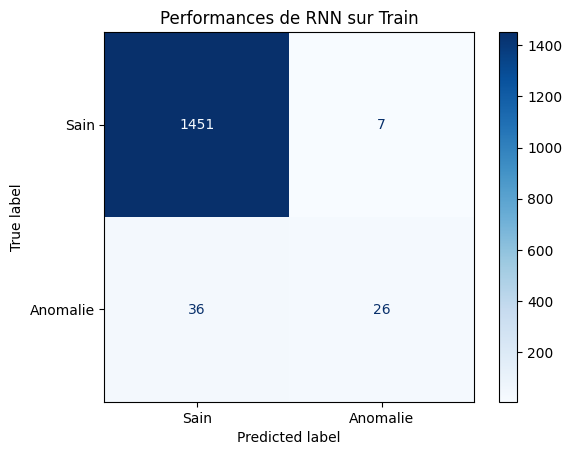

12/12 [==============================] - 0s 4ms/step


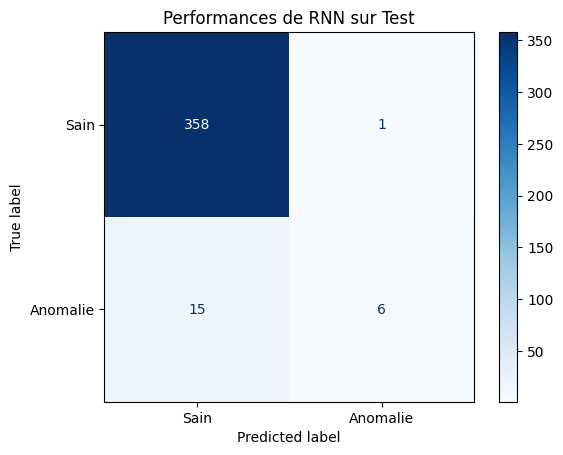

In [ ]:
pred=model.predict(dataFormat)
pred=np.round(pred)

falsePositiveTrain=0
falseNegativeTrain=0
for i in range(len(pred)):
  if(pred[i]!=yNeural[i]):
    if(pred[i]==0 and yNeural[i]==1): falseNegativeTrain=falseNegativeTrain+1
    else:falsePositiveTrain=falsePositiveTrain+1
neuralMatrixTrain.append(["RNN",falsePositiveTrain,falseNegativeTrain,len(yNeural),"{number}/{total}".format(number=sum(yNeural)-falseNegativeTrain,total=sum(yNeural))])

cm = confusion_matrix(yNeural, pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=["Sain","Anomalie"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Performances de RNN sur Train")
plt.show()

prediction=model.predict(testNeural)
prediction=np.round(prediction)

falsePositiveTest=0
falseNegativeTest=0
for i in range(len(prediction)):
  if(prediction[i]!=yVerifNeural[i]):
    if(prediction[i]==0 and yVerifNeural[i]==1): falseNegativeTest=falseNegativeTest+1
    else:falsePositiveTest=falsePositiveTest+1

cm = confusion_matrix(yVerifNeural, prediction)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=["Sain","Anomalie"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Performances de RNN sur Test")
plt.show()
neuralMatrixTest.append(["RNN",falsePositiveTest,falseNegativeTest,len(yVerifNeural),"{number}/{total}".format(number=sum(yVerifNeural)-falseNegativeTest,total=sum(yVerifNeural))])

## Classification binaire par CNN

In [ ]:
input_shape=[None,dataFormat.shape[2]]
modelCNN = Sequential(
    [
        Conv1D(filters=10, kernel_size=3, padding='same', activation='relu', input_shape=input_shape),
        Conv1D(filters=10, kernel_size=3, padding='same', activation='relu'),
        GlobalMaxPooling1D(),
        Dense(1)
    ]
)
modelCNN.summary()

modelCNN.compile(loss="MeanSquaredError", optimizer=tf.keras.optimizers.Adam(learning_rate=0.05), metrics=["MeanSquaredError"])
modelCNN.fit(dataFormat,yNeural, validation_split=.25, epochs=50,batch_size=32,verbose=1) #Use step_per_epochs if enough data, as its current value is 3

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, None, 10)          430       
                                                                 
 conv1d_1 (Conv1D)           (None, None, 10)          310       
                                                                 
 global_max_pooling1d (Glob  (None, 10)                0         
 alMaxPooling1D)                                                 
                                                                 
 dense_2 (Dense)             (None, 1)                 11        
                                                                 
Total params: 751 (2.93 KB)
Trainable params: 751 (2.93 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/50
36/36 [==============================] - 1s 9ms/step - loss: 0.0780 - mean_squa

48/48 [==============================] - 0s 2ms/step


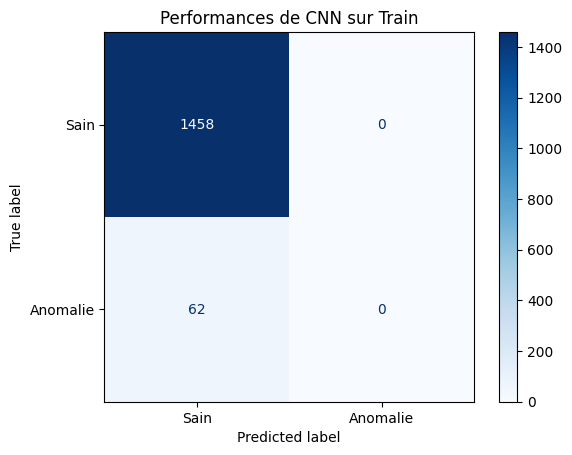

12/12 [==============================] - 0s 2ms/step


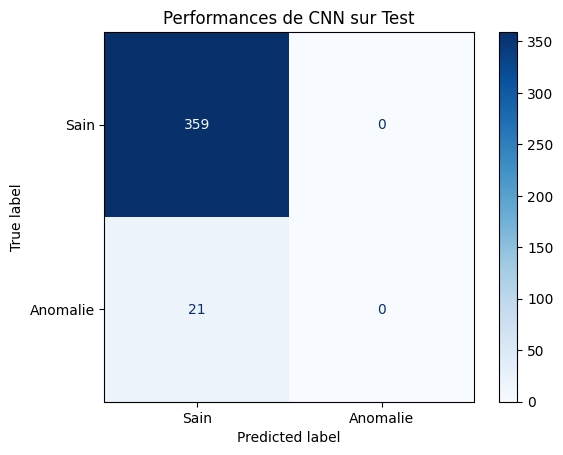

In [ ]:
pred=modelCNN.predict(dataFormat)
pred=np.round(pred)

#Sometimes there are 2s appearing
for i in range(len(pred)):
  if pred[i]==2: pred[i]=1
falsePositiveTrain=0
falseNegativeTrain=0
for i in range(len(pred)):
  if(pred[i]!=yNeural[i]):
    if(pred[i]==0 and yNeural[i]==1): falseNegativeTrain=falseNegativeTrain+1
    else:falsePositiveTrain=falsePositiveTrain+1
neuralMatrixTrain.append(["CNN",falsePositiveTrain,falseNegativeTrain,len(yNeural),"{number}/{total}".format(number=sum(yNeural)-falseNegativeTrain,total=sum(yNeural))])
cm = confusion_matrix(yNeural, pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=["Sain","Anomalie"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Performances de CNN sur Train")
plt.show()


prediction=modelCNN.predict(testNeural)
prediction=np.round(prediction)
for i in range(len(prediction)):
  if prediction[i]==2: prediction[i]=1
falsePositiveTest=0
falseNegativeTest=0
for i in range(len(prediction)):
  if(prediction[i]!=yVerifNeural[i]):
    if(prediction[i]==0 and yVerifNeural[i]==1): falseNegativeTest=falseNegativeTest+1
    else:falsePositiveTest=falsePositiveTest+1
neuralMatrixTest.append(["CNN",falsePositiveTest,falseNegativeTest,len(yVerifNeural),"{number}/{total}".format(number=sum(yVerifNeural)-falseNegativeTest,total=sum(yVerifNeural))])

cm = confusion_matrix(yVerifNeural, prediction)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=["Sain","Anomalie"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Performances de CNN sur Test")
plt.show()

## Préparation des données pour binaire/anomalie

In [ ]:
#Variables for 2D observation
var1="s3"
var2="s7"

#XPrep scaled
scalerPrep=StandardScaler()
scalerPrep.fit(XPrep)
XPrepScaled = scalerPrep.transform(XPrep)
XPrepScaled=pd.DataFrame(XPrepScaled,columns=colNames)

#Reduced in 2Dims
X2D=XPrepScaled.iloc[:,[XPrepScaled.columns.get_loc("s8"),XPrepScaled.columns.get_loc("s20")]].values
X2DnoScale=XPrep.iloc[:,[XPrep.columns.get_loc(var1),XPrep.columns.get_loc(var2)]].values

#This is the dataset composed of the 15 last observations for each engine of the train dataset, to test how good at anomaly detection our models are
XAnoScaled = scalerPrep.transform(XAno.drop(columns=["id"],axis=1))
XAnoScaled=pd.DataFrame(XAnoScaled,columns=colNames)

## Classification binaire par SVM

Nombre d'anomalies mal prédites:  417
Nombre d'anomalies bien prédites:  83
Nombre de points sains bien prédits:  20093
Nombre de points sains mal prédits:  38
              precision    recall  f1-score   support

           0       0.98      1.00      0.99     20131
           1       0.69      0.17      0.27       500

    accuracy                           0.98     20631
   macro avg       0.83      0.58      0.63     20631
weighted avg       0.97      0.98      0.97     20631



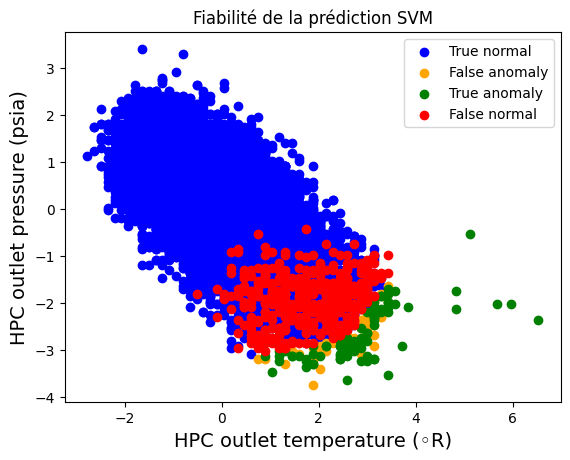

In [ ]:
from sklearn import svm
svm_model = svm.SVC()
svm_model.fit(X2D,yPrep)
pred=svm_model.predict(X2D)
errorAno,errorPure=realPlot("SVM",X2D,yPrep,pred,var1,var2)
print(classification_report(yPrep,pred))
anomalyResultsTrain.append(["SVM",var1,var2,accuracy_score(yPrep,pred),errorAno,errorPure])

## Régression logistique

In [ ]:
from sklearn.linear_model import LogisticRegression
import math
model = LogisticRegression(max_iter=1000)
model.fit(XPrepScaled, yPrep)

pred=model.predict(XPrepScaled)
model.score(XPrepScaled,yPrep)

print("Accuracy Score :")
acc=accuracy_score(yPrep,pred)
print(acc)
print("Classification Report :")
report=classification_report(yPrep,pred)
print(report)

yPlot=yPrep.tolist()
green=[] #Anomaly correctly predicted
red=[] #Anomaly wrongly predicted
blue=[] #Normal correctly predicted
orange=[] #Normal wrongly predicted
for i in range(len(yPlot)):
  if  yPlot[i]==1 and pred[i]==1 :
    green.append(XPrepScaled.iloc[i])
  elif yPlot[i]==0 and pred[i]==0:
    blue.append(XPrepScaled.iloc[i])
  elif yPlot[i]==0 and pred[i]==1:
    orange.append(XPrepScaled.iloc[i])
  else:
    red.append(XPrep.iloc[i])

nbOutliers=sum(yPlot)
nbPure=len(yPlot)-nbOutliers
errorAno="{number}/{total}".format(number=len(red),total=nbOutliers)
errorPure="{number}/{total}".format(number=len(orange),total=nbPure)

anomalyResultsTrain.append(["Régression logistique","","",acc,errorAno,errorPure])

Accuracy Score :
0.9886578449905482
Classification Report :
              precision    recall  f1-score   support

           0       0.99      0.99      0.99     20131
           1       0.78      0.74      0.76       500

    accuracy                           0.99     20631
   macro avg       0.89      0.87      0.88     20631
weighted avg       0.99      0.99      0.99     20631



Nombre d'anomalies mal prédites:  363
Nombre d'anomalies bien prédites:  137
Nombre de points sains bien prédits:  20041
Nombre de points sains mal prédits:  90


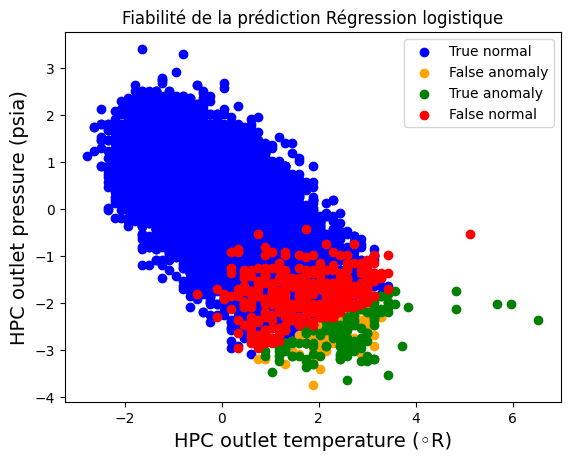

In [ ]:
model = LogisticRegression(max_iter=1000,penalty="l2",solver="lbfgs")
model.fit(X2D, yPrep)
pred=model.predict(X2D)
model.score(X2D,yPrep)
errorAno,errorPure=realPlot("Régression logistique",X2D,yPrep,pred,var1,var2)
anomalyResultsTrain.append(["Régression logistique",var1,var2,accuracy_score(yPrep,pred),errorAno,errorPure])

# Détection d'anomalies

## Détection d'anomalies avec Isolation Forest

In [ ]:
isolationForest = IsolationForest(random_state=10000).fit(XPrepScaled)
scores_prediction = isolationForest.decision_function(XPrepScaled)
pred=isolationForest.predict(XPrepScaled)
pred[pred == 1] = 0
pred[pred == -1] = 1
print("Accuracy Score :")
acc=accuracy_score(yPrep,pred)
print(acc)
print("Classification Report :")
report=classification_report(yPrep,pred)
print(report)

green=[] #Anomaly correctly predicted
red=[] #Anomaly wrongly predicted
blue=[] #Normal correctly predicted
orange=[] #Normal wrongly predicted
for i in range(len(yPlot)):
  if  yPlot[i]==1 and pred[i]==1 :
    green.append(XPrepScaled.iloc[i])
  elif yPlot[i]==0 and pred[i]==0:
    blue.append(XPrepScaled.iloc[i])
  elif yPlot[i]==0 and pred[i]==1:
    orange.append(XPrepScaled.iloc[i])
  else:
    red.append(XPrepScaled.iloc[i])

nbOutliers=sum(yPlot)
nbPure=len(yPlot)-nbOutliers
errorAno="{number}/{total}".format(number=len(red),total=nbOutliers)
errorPure="{number}/{total}".format(number=len(orange),total=nbPure)
anomalyResultsTrain.append(["Isolation Forest FullDim","","",acc,errorAno,errorPure])

predictions=isolationForest.predict(X_test)
outliers=0
tot=len(predictions)
predictions[predictions == 1] = 0
predictions[predictions == -1] = 1
for e in predictions:
  if e==1:outliers+=1
proport=outliers/tot*100
print("Pourcentage d'anomalies détectées sur Test: ",proport)

Accuracy Score :
0.8989384906209102
Classification Report :
              precision    recall  f1-score   support

           0       1.00      0.90      0.95     20131
           1       0.19      1.00      0.32       500

    accuracy                           0.90     20631
   macro avg       0.60      0.95      0.63     20631
weighted avg       0.98      0.90      0.93     20631

Pourcentage d'anomalies détectées sur Test:  100.0


Nombre d'anomalies mal prédites:  35
Nombre d'anomalies bien prédites:  465
Nombre de points sains bien prédits:  15388
Nombre de points sains mal prédits:  4743


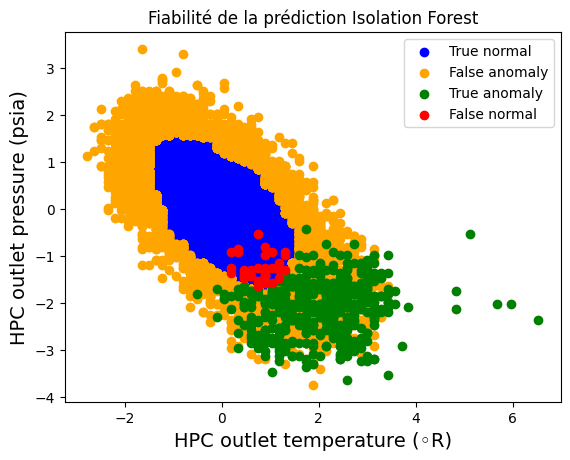

In [ ]:
clf =  IsolationForest(random_state=4294967295)
clf.fit(X2D)
scores_prediction = clf.decision_function(X2D)
pred=clf.predict(X2D)
pred[pred == 1] = 0
pred[pred == -1] = 1
errorAno,errorPure=realPlot("Isolation Forest",X2D,yPrep,pred,var1,var2)
anomalyResultsTrain.append(["Isolation Forest",var1,var2,acc,errorAno,errorPure])

## Détection d'anomalies avec SVM 1-classe

Accuracy Score :
0.9728079104260579
Classification Report :
              precision    recall  f1-score   support

           0       0.98      0.99      0.99     20131
           1       0.35      0.14      0.20       500

    accuracy                           0.97     20631
   macro avg       0.66      0.57      0.59     20631
weighted avg       0.96      0.97      0.97     20631

Nombre d'anomalies mal prédites:  429
Nombre d'anomalies bien prédites:  71
Nombre de points sains bien prédits:  19999
Nombre de points sains mal prédits:  132


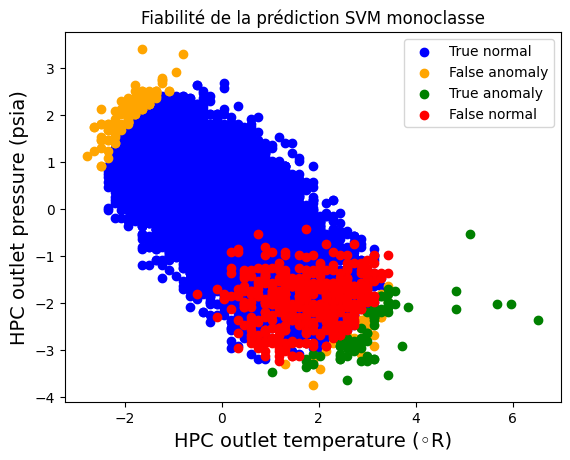

In [ ]:
model= svm.OneClassSVM(kernel="rbf",gamma=0.001,nu=0.01) #0.9 and 0.2
model.fit(X2D)
pred=model.predict(X2D)
perf=pred.copy()
perf[perf == 1] = 0
perf[perf == -1] = 1
print("Accuracy Score :")
print(accuracy_score(yPrep,perf))
print("Classification Report :")
print(classification_report(yPrep,perf))
errorAno,errorPure=realPlot("SVM monoclasse",X2D,yPrep,perf,var1,var2)
anomalyResultsTrain.append(["SVM monoclasse",var1,var2,accuracy_score(yPrep,perf),errorAno,errorPure])

# Analyse des résultats

In [ ]:
printResMatrix(resultMatrixTrain,resultMatrixTest,resMatrixNames,"res")
printResMatrix(anomalyResultsTrain,anomalyResultsTest,anomalyNames,"ano")
printResMatrix(neuralMatrixTrain,neuralMatrixTest,neuralNames,"neural")

Les résultats des modèles en Train, triés par RMSE décroissant:
+--------------------------+----------+----------+---------------+------------+-------------+
| Model                    |     RMSE |       R² |   TooMuchProp |   OverMean |   UnderMean |
+==========================+==========+==========+===============+============+=============+
| Régression Random Forest |  6.78944 | 0.973456 |      0.394988 |    6.07004 |     4.23105 |
+--------------------------+----------+----------+---------------+------------+-------------+
| Régression XgBoost       | 18.3034  | 0.807088 |      0.409093 |   16.5256  |    11.4734  |
+--------------------------+----------+----------+---------------+------------+-------------+
| Régression simple        | 21.491   | 0.734043 |      0.523726 |   16.7915  |    18.4646  |
+--------------------------+----------+----------+---------------+------------+-------------+


Les résultats des modèles en Test, triés par RMSE décroissant:
+------------------------

# Matrice de résultats d'anomalies

<Axes: title={'center': "Pourcentage d'anomalies par paires de capteurs, moteur 40"}>

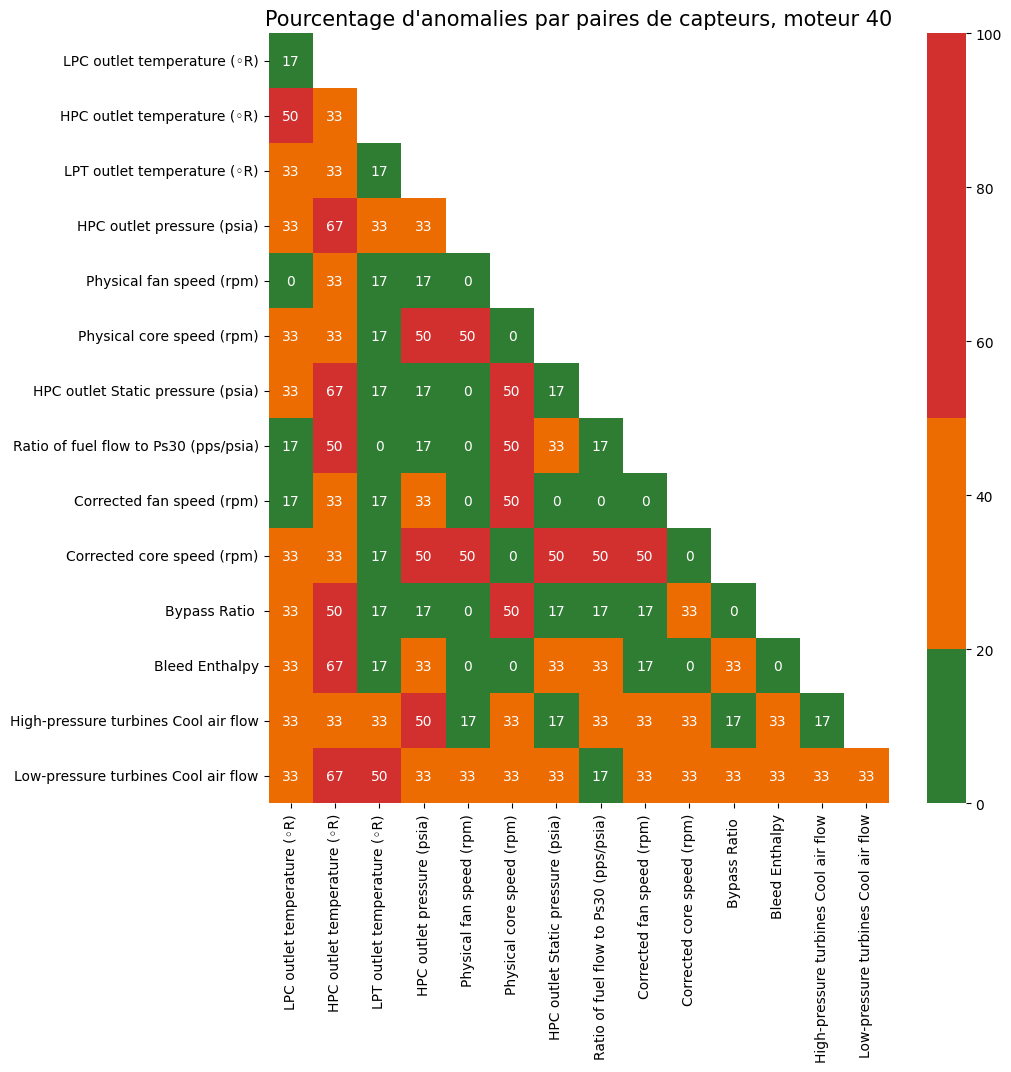

In [ ]:
from  matplotlib.colors import LinearSegmentedColormap
from  matplotlib.colors import ListedColormap

motorChoice=40

# To optimize: it works, but could be better
def createFinalMatrix(trainValues,yValues,anomalies,motorID):
  colNames=list(trainValues.columns)
  anomalies=anomalies[anomalies['id']==motorID]
  scaler=StandardScaler()
  scaler.fit(trainValues)
  trainValuesScaled = scaler.transform(trainValues)
  trainValuesScaled=pd.DataFrame(trainValuesScaled,columns=colNames)
  anomaliesScaled = scaler.transform(anomalies.drop(columns=["id"],axis=1))
  anomaliesScaled=pd.DataFrame(anomaliesScaled,columns=colNames)

  matrix=np.zeros(shape=(trainValues.shape[1],trainValues.shape[1])) #Problème de nom pour X
  for i in range(len(colNames)):
    for j in range(len(colNames)):
      X=trainValuesScaled.iloc[:,[trainValuesScaled.columns.get_loc(colNames[i]),trainValuesScaled.columns.get_loc(colNames[j])]].values
      ano2D=anomaliesScaled.iloc[:,[anomaliesScaled.columns.get_loc(colNames[i]),anomaliesScaled.columns.get_loc(colNames[j])]].values
      model = LogisticRegression(max_iter=1000)
      model.fit(X,yValues)
      prediction=model.predict(ano2D) #Make a prediction on the test dataset composed of supposed anomalies
      percentAno=sum(prediction)/len(prediction)*100
      matrix[j][i]=matrix[i][j]=percentAno
  return matrix

plt.rcParams["figure.figsize"] = (10,10)

#We use the App's colors
blueApp = np.array([2/256, 136/256, 209/256, 1])
redApp=np.array([211/256, 47/256, 47/256, 1])
orangeApp=np.array([237/256, 108/256, 2/256, 1])
greenApp=np.array([46/256, 125/256, 50/256, 1])
cmap=ListedColormap([greenApp,greenApp,orangeApp,orangeApp,orangeApp,redApp,redApp,redApp,redApp,redApp]) #Colors represent percentages: 5/10 red => 50%

matrix=createFinalMatrix(XPrep,yPrep,XAno,motorChoice)

mask = np.triu(np.ones((X_train.shape[1],X_train.shape[1]),dtype=bool))
ind = np.diag_indices_from(mask)#Get the mask's diagonal
mask[ind] = False #We exclude the diagonal from the mask

#Titles and labels
alpha=[]
for e in X_train.columns: alpha.append(paramDictionary[e])
x_axis_labels=alpha
y_axis_labels=alpha
title="Pourcentage d'anomalies par paires de capteurs, moteur {idMotor}".format(idMotor=motorChoice)
plt.title(title,fontsize=15)

sns.heatmap(matrix,xticklabels=x_axis_labels,yticklabels=y_axis_labels,annot=True,mask=mask,cmap=cmap,vmin=0,vmax=100)